# Fare Choice Prediction Challenge

### A passenger has different options when it comes to booking a flight ticket. It can be classic fare(no scope for cancellation), saver fare(discounted fare), flexible fare(scope for cancellation) etc. 
### Predicting this demand correctly before hand can give airlines advantages in maximizing its revenue and also better plan the fare distribution.
### This exercise aims to predict the probablity of booking of each of the four different fare choices available to a passenger based on features such as booking date, departure date, origin, destination, no. of passengers etc.
### NOTE: The orign, destination and the fare choice are encoded to maintain confidentiality of the data. As these are categorical, the encoding in no way affects the working of the model. It only masks the actual categories these columns represents.
### We use a Random Forest Model to solve the problem in hand and also use log_loss(cross entropy) as the metric which we are trying to minimize.

In [1]:
from IPython.core.display import display, HTML
display(HTML(
    "<style>.container { width:95% !important; } .dataframe td {white-space: nowrap; } </style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# import statements
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, log_loss, f1_score, accuracy_score

%matplotlib inline
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)

In [3]:
def build_features(df):
    """
    Feature Engineering with the help of existing columns

    Args:
        df (str): Dataframe to be enriched.

    Returns:
        DataFrame. The enriched dataframe with new features
    """
    df = df.copy(deep=True)
    # Extract date related features wrt booking date.
    df['booking_month'] = df['booking_date'].dt.month
    df['booking_week'] = df['booking_date'].dt.isocalendar().week
    df['booking_day'] = df['booking_date'].dt.weekday

    # Extract time and date related features wrt departure date.
    df['dep_day'] = df['dep_date'].dt.weekday
    df['dep_time_str'] =  np.where(df['dep_time'] < 1000, '0' + df['dep_time'].astype(str), df['dep_time'].astype(str))
    df['dep_hour'] = df['dep_time_str'].str[:2].astype(int)
    # Introduce sine and cosine components as 00:00 and 23:00 hrs are close to each other.
    # Without this cyclic representation, they will be far apart in linear representation.
    df['dep_hour_sine'] = np.sin(2 * math.pi * (df['dep_hour'] / 23))
    df['dep_hour_cosine'] = np.cos(2 * math.pi * (df['dep_hour'] / 23))

    # Calculate the number of days before which the flight was booked.
    df['advance_purchase'] = (df['dep_date'] - df['booking_date']).dt.days

    return df



#### fare_choice represents the dependent variable and all other columns are independent features

In [4]:
# Read in the training data
train_df = pd.read_csv('train_encoded.csv', sep='^', na_filter=False, low_memory=False,
                       parse_dates=['booking_date', 'dep_date'], infer_datetime_format=True)

train_df.shape
train_df.head()

(73830, 8)

,id,booking_date,origin,destination,dep_date,dep_time,pax,fare_choice
0,1,2017-02-10,G,D,2017-06-01,630,2,2
1,2,2017-05-27,D,B,2017-06-01,1745,1,1
2,3,2017-05-30,B,D,2017-06-01,900,1,4
3,4,2017-05-30,B,A,2017-06-01,2130,2,1
4,5,2017-05-30,D,B,2017-06-01,1240,1,1


## EDA

#### We see that there are no missing values. Just to make sure, we check unique values for categories and see that they don't represent any misisng values such as '?' or '-'

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73830 entries, 0 to 73829
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            73830 non-null  int64         
 1   booking_date  73830 non-null  datetime64[ns]
 2   origin        73830 non-null  object        
 3   destination   73830 non-null  object        
 4   dep_date      73830 non-null  datetime64[ns]
 5   dep_time      73830 non-null  int64         
 6   pax           73830 non-null  int64         
 7   fare_choice   73830 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 4.5+ MB


#### The unique values seem good. There are 7 unique origins and 5 unique destinations

In [6]:
train_df['origin'].unique()
train_df['destination'].unique()

array(['G', 'D', 'B', 'A', 'F', 'E', 'C'], dtype=object)

array(['D', 'B', 'A', 'C', 'G'], dtype=object)

#### Convert the object type features and the prediction variable to categories

In [7]:
train_df['origin'] = train_df['origin'].astype('category')
train_df['destination'] = train_df['destination'].astype('category')
train_df['fare_choice'] = train_df['fare_choice'].astype('category')

In [8]:
train_df.describe(include='all')

<ipython-input-8-1e2903f7da16>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train_df.describe(include='all')


,id,booking_date,origin,destination,dep_date,dep_time,pax,fare_choice
count,73830.000000,73830,73830,73830,73830,73830.000000,73830.000000,73830.0
unique,NaN,200,7,5,23,NaN,NaN,4.0
top,NaN,2017-06-02 00:00:00,B,B,2017-06-23 00:00:00,NaN,NaN,1.0
freq,NaN,3822,22360,32962,3774,NaN,NaN,30843.0
first,NaN,2016-06-11 00:00:00,NaN,NaN,2017-06-01 00:00:00,NaN,NaN,NaN
last,NaN,2017-06-23 00:00:00,NaN,NaN,2017-06-23 00:00:00,NaN,NaN,NaN
mean,36915.500000,NaN,NaN,NaN,NaN,1322.905255,1.352987,NaN
std,21313.029524,NaN,NaN,NaN,NaN,542.624205,0.828914,NaN
min,1.000000,NaN,NaN,NaN,NaN,145.000000,1.000000,NaN
25%,18458.250000,NaN,NaN,NaN,NaN,810.000000,1.000000,NaN


In [9]:
# Extract some relevent features from available columns
train_df = build_features(train_df)
train_df.shape
train_df.head()

(73830, 17)

,id,booking_date,origin,destination,dep_date,dep_time,pax,fare_choice,booking_month,booking_week,booking_day,dep_day,dep_time_str,dep_hour,dep_hour_sine,dep_hour_cosine,advance_purchase
0,1,2017-02-10,G,D,2017-06-01,630,2,2,2,6,4,3,0630,6,0.997669,-0.068242,111
1,2,2017-05-27,D,B,2017-06-01,1745,1,1,5,21,5,3,1745,17,-0.997669,-0.068242,5
2,3,2017-05-30,B,D,2017-06-01,900,1,4,5,22,1,3,0900,9,0.631088,-0.775711,2
3,4,2017-05-30,B,A,2017-06-01,2130,2,1,5,22,1,3,2130,21,-0.519584,0.854419,2
4,5,2017-05-30,D,B,2017-06-01,1240,1,1,5,22,1,3,1240,12,-0.136167,-0.990686,2


## Visual Analysis

#### We see that fare_choice 1 is the majority class and fare_choice 3 is the minority.
#### We see that there are two peaks in departure hours. One around 7-8 AM and other around 6-8PM
#### Cities B and D form bulk of origin and destinations

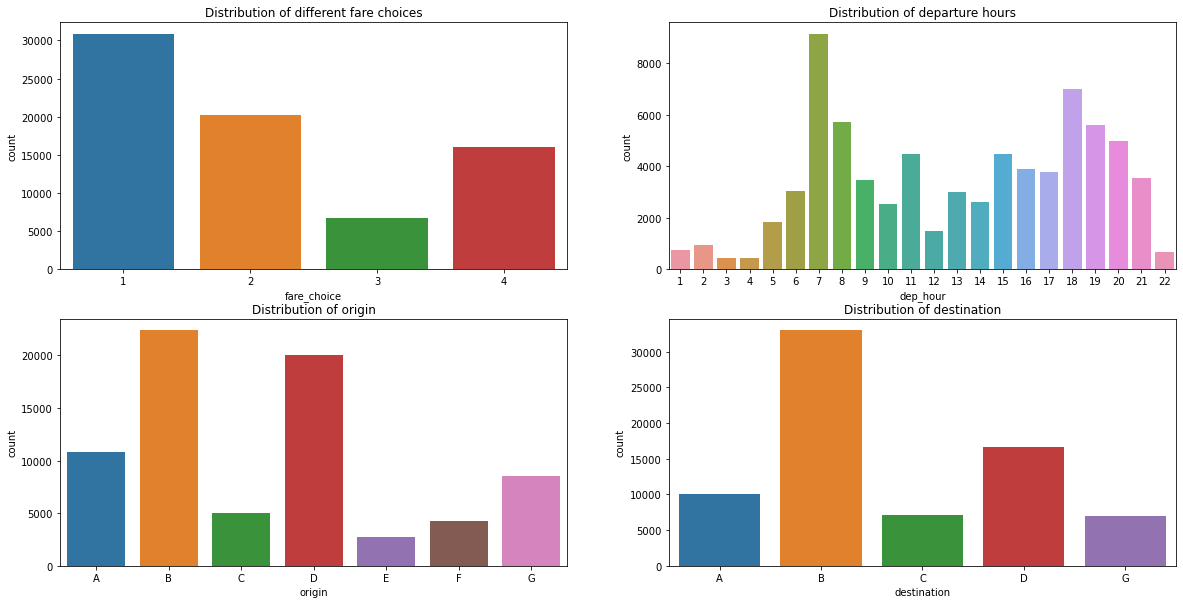

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

g = sns.countplot(x='fare_choice', data=train_df, ax=ax[0][0])
_ = g.set_title('Distribution of different fare choices')

g = sns.countplot(x='dep_hour', data=train_df, ax=ax[0][1])
_ = g.set_title('Distribution of departure hours')

g = sns.countplot(x='origin', data=train_df, ax=ax[1][0])
_ = g.set_title('Distribution of origin')

g = sns.countplot(x='destination', data=train_df, ax=ax[1][1])
_ = g.set_title('Distribution of destination')

#### From the below figure, we can see that fare_choice 2 is the one preferred by early bookers followed by fare_choice 4. Fare choice 1 is used when booking date is closer to departure date.

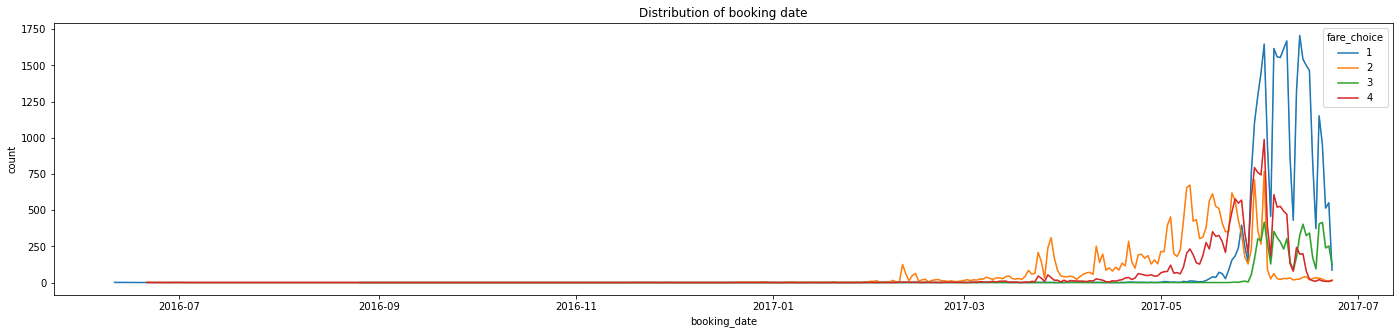

In [11]:
_ = plt.figure(figsize=[24, 5])
train_df['count'] = 1
g = sns.lineplot(x='booking_date', y='count', hue='fare_choice', estimator='sum', data=train_df)
_ = g.set_title('Distribution of booking date')

#### We don't see any strong trends wrt number of bookings for different departure dates

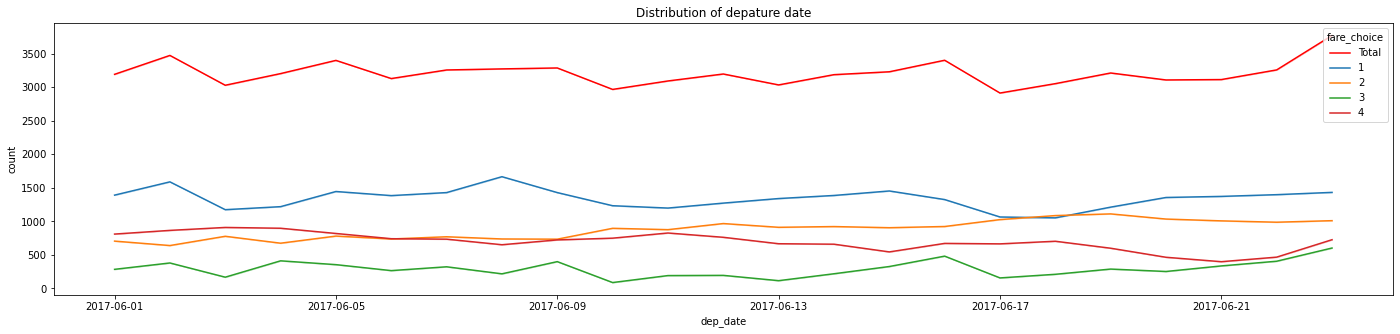

In [12]:
_ = plt.figure(figsize=[24,5])
_ = sns.lineplot(x='dep_date', y='count', estimator='sum', data=train_df, color='r', label='Total')
g = sns.lineplot(x='dep_date', y='count', hue='fare_choice', estimator='sum', data=train_df)
_ = g.set_title('Distribution of depature date')

#### Below plot clearly illustrates that fare_choice 2 dominates the early bookings. fare_choice 4 takes over around 3 weeks for depature and fare_choice 1 is dominant when there is only a week left for departure

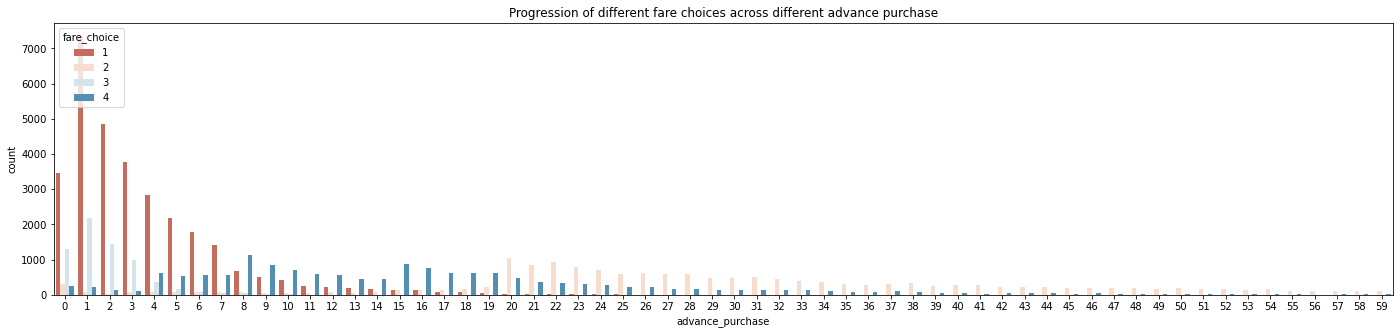

In [13]:
_ = plt.figure(figsize=[24, 5])
g = sns.countplot(x='advance_purchase', data=train_df[train_df['advance_purchase'] < 60], hue='fare_choice', palette='RdBu')
_ = g.set_title('Progression of different fare choices across different advance purchase')

#### Below plot shows how the different fare_choices are dominant in differnt markets

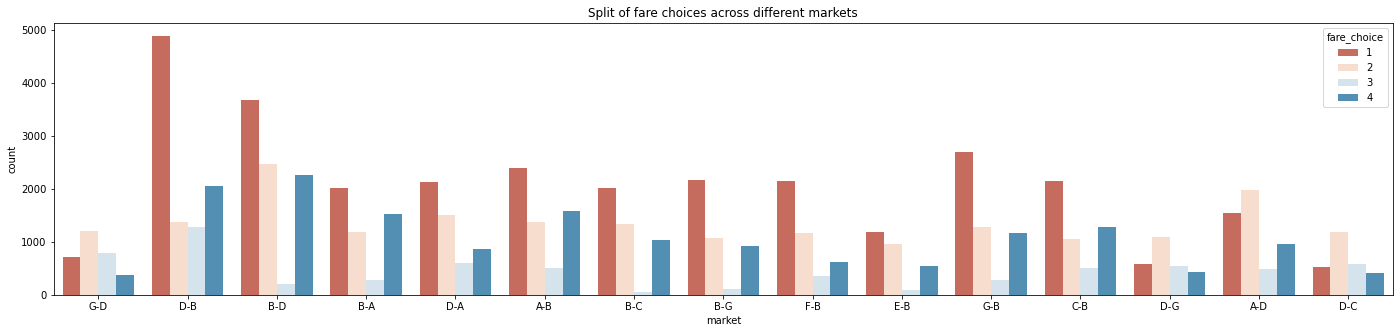

In [14]:
_ = plt.figure(figsize=[24, 5])
train_df['market'] = train_df['origin'].astype(str) + '-' + train_df['destination'].astype(str)
g = sns.countplot(x='market', data=train_df, hue='fare_choice', palette='RdBu')
_ = g.set_title('Split of fare choices across different markets')

## Prepare the dataset for model building

In [15]:
# One hot encode the categorical variables
train_df = pd.get_dummies(train_df, columns=['origin', 'destination', 'booking_day', 'dep_day'], drop_first=True)
train_df.shape
train_df.head()

(73830, 37)

,id,booking_date,dep_date,dep_time,pax,fare_choice,booking_month,booking_week,dep_time_str,dep_hour,dep_hour_sine,dep_hour_cosine,advance_purchase,count,market,origin_B,origin_C,origin_D,origin_E,origin_F,origin_G,destination_B,destination_C,destination_D,destination_G,booking_day_1,booking_day_2,booking_day_3,booking_day_4,booking_day_5,booking_day_6,dep_day_1,dep_day_2,dep_day_3,dep_day_4,dep_day_5,dep_day_6
0,1,2017-02-10,2017-06-01,630,2,2,2,6,0630,6,0.997669,-0.068242,111,1,G-D,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1,2,2017-05-27,2017-06-01,1745,1,1,5,21,1745,17,-0.997669,-0.068242,5,1,D-B,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,3,2017-05-30,2017-06-01,900,1,4,5,22,0900,9,0.631088,-0.775711,2,1,B-D,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
3,4,2017-05-30,2017-06-01,2130,2,1,5,22,2130,21,-0.519584,0.854419,2,1,B-A,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,5,2017-05-30,2017-06-01,1240,1,1,5,22,1240,12,-0.136167,-0.990686,2,1,D-B,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [16]:
# We load the test set which also has actual booked fare_choice. We will use this to verify final log_loss on the test data

In [17]:
test_df = pd.read_csv('test_encoded.csv', sep='^', na_filter=False, low_memory=False,
                       parse_dates=['booking_date', 'dep_date'], infer_datetime_format=True)

test_df.shape
test_df.head()

(22830, 8)

,id,booking_date,origin,destination,dep_date,dep_time,pax,fare_choice
0,73831,2017-04-21,A,D,2017-06-24,1745,2,2
1,73832,2017-05-24,B,D,2017-06-24,1700,2,2
2,73833,2017-04-12,A,D,2017-06-24,700,1,2
3,73834,2017-06-21,A,D,2017-06-24,1125,2,3
4,73835,2017-05-31,B,C,2017-06-24,1905,1,4


In [18]:
test_df = build_features(test_df)
test_df = pd.get_dummies(test_df, columns=['origin', 'destination', 'booking_day', 'dep_day'], drop_first=True)

test_df.shape
test_df.head()

(22830, 35)

,id,booking_date,dep_date,dep_time,pax,fare_choice,booking_month,booking_week,dep_time_str,dep_hour,dep_hour_sine,dep_hour_cosine,advance_purchase,origin_B,origin_C,origin_D,origin_E,origin_F,origin_G,destination_B,destination_C,destination_D,destination_G,booking_day_1,booking_day_2,booking_day_3,booking_day_4,booking_day_5,booking_day_6,dep_day_1,dep_day_2,dep_day_3,dep_day_4,dep_day_5,dep_day_6
0,73831,2017-04-21,2017-06-24,1745,2,2,4,16,1745,17,-0.997669,-0.068242,64,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
1,73832,2017-05-24,2017-06-24,1700,2,2,5,21,1700,17,-0.997669,-0.068242,31,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
2,73833,2017-04-12,2017-06-24,700,1,2,4,15,0700,7,0.942261,-0.334880,73,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
3,73834,2017-06-21,2017-06-24,1125,2,3,6,25,1125,11,0.136167,-0.990686,3,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
4,73835,2017-05-31,2017-06-24,1905,1,4,5,22,1905,19,-0.887885,0.460065,24,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [19]:
# Select required features and define training and test dataset
X_train = train_df[['booking_month', 'booking_week', 'booking_day_1', 'booking_day_2', 'booking_day_3', 'booking_day_4', 'booking_day_5', 'booking_day_6',
                    'dep_hour', 'advance_purchase', 'dep_day_1', 'dep_day_2', 'dep_day_3', 'dep_day_4', 'dep_day_5', 'dep_day_6',
                    'origin_B', 'origin_C', 'origin_D', 'origin_F', 'origin_G',
                    'destination_B', 'destination_C', 'destination_D', 'destination_G',
                    'pax']]
y_train = train_df['fare_choice']

X_test = test_df[['booking_month', 'booking_week', 'booking_day_1', 'booking_day_2', 'booking_day_3', 'booking_day_4', 'booking_day_5', 'booking_day_6',
                    'dep_hour', 'advance_purchase', 'dep_day_1', 'dep_day_2', 'dep_day_3', 'dep_day_4', 'dep_day_5', 'dep_day_6',
                    'origin_B', 'origin_C', 'origin_D', 'origin_F', 'origin_G',
                    'destination_B', 'destination_C', 'destination_D', 'destination_G',
                    'pax']]
y_true = test_df['fare_choice']

print(X_train.shape)
print(X_test.shape)

(73830, 26)
(22830, 26)


## Model Building

#### Parameter tuning of Random Forest using Randomized Grid Search

In [20]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [21]:
rf = RandomForestClassifier(random_state=5)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, scoring='neg_log_loss', cv=3, verbose=1, n_jobs=-1)
rf_random.fit(X_train, y_train)
rf_random.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=5),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='neg_log_loss', verbose=1)

{'n_estimators': 1200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

### Use the best model and predict probabilities. Calculate log_loss and other metrics

In [24]:
final_model = RandomForestClassifier(n_estimators=1200,
                                     min_samples_split=10,
                                     min_samples_leaf=4,
                                     max_features='auto',
                                     max_depth=20,
                                     bootstrap=True,
                                     random_state=5,
                                     n_jobs=-1)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

pred_prob = final_model.predict_proba(X_test)


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=1200, n_jobs=-1, random_state=5)

In [25]:
print('Log Loss of the model: ', log_loss(y_true, pred_prob))
print('Accuaracy of the model:' , (accuracy_score(y_true, y_pred)) * 100)
print('Macro F1 score of the model:', (f1_score(y_true, y_pred, average='macro')) * 100)

Log Loss of the model:  0.6431332270523202
Accuaracy of the model: 75.13797634691196
Macro F1 score of the model: 70.93332005108803
